# Commitment Across Distance Conditions — 2P3G

This notebook analyzes commitment across distance conditions for 2P3G trials,
using helper logic adapted from `commitment_across_distance_conditions_clean.ipynb` to:
- Reconstruct player positions at the new-goal moment.
- Validate that distance conditions reflect the true distances to the new goal.
- Compute commitment rates across partner types: human–human, human–GPT, human–individual RL, and human–joint RL.

In [524]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')

# Color scheme matching streamlined_collaboration_analysis_complete.ipynb
CONDITION_COLORS = {
    'human_human': '#2E86C1',        # Blue (matches 'human')
    'human_gpt': '#E74C3C',          # Red (matches 'gpt-4.1-mini')
    'individual_rl': '#28B463',      # Green
    'joint_rl': '#F39C12',           # Orange
    'joint-rl-realTime': '#8E44AD'   # Purple (matching streamlined analysis exactly)
}

BASE = Path('.')  # assume running from dataAnalysis/
PATH_HH_GPT = BASE / 'human-human-with-gpt-fallback' / 'combined_experiment_data.csv'
PATH_HH_GPT_XLSX_DIR = BASE / 'human-human-with-gpt-fallback' / 'data-original'
PATH_RL_DIR = BASE / 'human-RLs' / 'data-original'

print('Paths:')
print('  human-human/GPT combined:', PATH_HH_GPT.resolve())
print('  HH/GPT xlsx dir:', PATH_HH_GPT_XLSX_DIR.resolve())
print('  RL xlsx dir:', PATH_RL_DIR.resolve())

Paths:
  human-human/GPT combined: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/combined_experiment_data.csv
  HH/GPT xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/data-original
  RL xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-RLs/data-original


In [525]:
# Extra path for HH/GPT raw Excel fallback
PATH_HH_GPT_XLSX_DIR = BASE / 'human-human-with-gpt-fallback' / 'data-original'
print('  HH/GPT xlsx dir:', PATH_HH_GPT_XLSX_DIR.resolve())


  HH/GPT xlsx dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-human-with-gpt-fallback/data-original


## Helper Functions (from cleaned distance notebook)
Copied/adapted from `commitment_across_distance_conditions_clean.ipynb` to ensure identical distance reconstruction logic.

In [526]:
def parse_point(value):
    if value is None:
        return None
    s = str(value).strip()
    if s == '' or s in {'[]'}:
        return None
    if s.lower() in {'nan', 'none', 'null'}:
        return None
    try:
        return tuple(ast.literal_eval(s))
    except Exception:
        return None

def parse_positions(value):
    if value is None:
        return []
    s = str(value).strip()
    if s == '' or s == '[]':
        return []
    try:
        return [tuple(x) for x in ast.literal_eval(s)]
    except Exception:
        return []

# Safe versions for use in other functions
def _safe_parse_point(value):
    """Safe version of parse_point - same as parse_point but with _safe prefix"""
    return parse_point(value)

def _safe_parse_positions(value):
    """Safe version of parse_positions - same as parse_positions but with _safe prefix"""
    return parse_positions(value)

def _vector_add(vec1, vec2):
    """Add two coordinate vectors element-wise"""
    if vec1 is None or vec2 is None:
        return None
    try:
        return (vec1[0] + vec2[0], vec1[1] + vec2[1])
    except (IndexError, TypeError):
        return None

# Commitment calculation helper functions
def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def _to_index_or_none(x):
    try:
        v = int(float(x))
        return v if v in (0,1,2) else None  # Allow 0,1,2 for goal indices
    except Exception:
        return None

def _get_human_partner_indices(row):
    # Hard-code for RL conditions: human is always player1 (index 0)
    grp = str(row.get('partner_group','')).strip().lower()
    if grp in ('individual_rl','joint_rl','joint-rl-realtime'):
        human_idx = 0
        partner_idx = 1
        return human_idx, partner_idx
    # Prefer explicit indices otherwise
    human_idx = _to_index_or_none(row.get('humanPlayerIndex'))
    ai_idx = _to_index_or_none(row.get('aiPlayerIndex'))
    if human_idx is None and ai_idx is not None:
        human_idx = 1 - ai_idx
    # Fallbacks by partner_group
    if human_idx is None:
        if grp == 'human_human':
            human_idx = 0  # assume player1 as participant
        elif ai_idx is not None:
            human_idx = 1 - ai_idx
    partner_idx = 1 - human_idx if human_idx is not None else None
    return human_idx, partner_idx

def _commitment_for_index(row, idx):
    """
    Commitment = whether first detected shared goal equals final reached goal
    for the given player index (0 or 1)
    """
    if idx not in (0,1):
        return np.nan

    # Get first detected shared (joint) goal
    first_shared = _to_int_or_nan(row.get('firstDetectedSharedGoal'))

    # Get final reached goal for the player
    if idx == 0:
        final_goal = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    else:
        final_goal = _to_int_or_nan(row.get('player2FinalReachedGoal'))

    if np.isnan(first_shared) or np.isnan(final_goal):
        return np.nan

    return 1.0 if first_shared == final_goal else 0.0

def commitment_human(row):
    human_idx, _ = _get_human_partner_indices(row)
    return _commitment_for_index(row, human_idx)

def commitment_partner(row):
    human_idx, partner_idx = _get_human_partner_indices(row)
    return _commitment_for_index(row, partner_idx)

def attach_commitment(df):
    df = df.copy()
    df['commitment_human'] = df.apply(commitment_human, axis=1)
    df['commitment_partner'] = df.apply(commitment_partner, axis=1)
    return df

def compress_positions(seq):
    out = []
    for p in seq:
        if not out or p != out[-1]:
            out.append(p)
    return out

def get_human_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player1Trajectory'))
    if step < len(traj):
        return traj[step]
    # fallback: reconstruct from init + actions if available
    pos = parse_point(row.get('initPlayerGrid'))
    actions = parse_positions(row.get('player1Actions'))
    if pos is None or not actions:
        return traj[-1] if traj else None
    for idx, act in enumerate(actions, start=1):
        pos = (pos[0] + act[0], pos[1] + act[1])
        if idx == step:
            return pos
    return pos

def get_ai_pos_at_new(row):
    step_val = row.get('newGoalPresentedTime')
    if step_val in (None, ''):
        return None
    step = int(float(step_val))
    traj = parse_positions(row.get('player2Trajectory'))
    if not traj:
        # Fallback to initial AI grid if present
        return parse_point(row.get('initAIGrid'))
    # Prefer AI state after each human step: odd indices 1,3,5,...
    odd_positions = [traj[i] for i in range(1, len(traj), 2)]
    if odd_positions:
        idx = min(step, len(odd_positions)-1)
        return odd_positions[idx]
    # Fallback: clamp 2*step-1 into raw trajectory
    idx = max(0, min(len(traj)-1, 2*step - 1))
    return traj[idx]

def get_goal_index_at_new(row, step):
    # Check player1CurrentGoal then player2CurrentGoal for a non-null index at (step-1)
    for col in ('player1CurrentGoal', 'player2CurrentGoal'):
        raw = row.get(col)
        if not raw:
            continue
        raw = str(raw).replace('null', 'None')
        try:
            arr = ast.literal_eval(raw)
        except Exception:
            continue
        if not isinstance(arr, list) or not arr:
            continue
        idx = max(0, min(step-1, len(arr)-1))
        val = arr[idx]
        if val is not None:
            try:
                return int(val)
            except Exception:
                pass
    return 0

def manhattan(a, b):
    if a is None or b is None:
        return np.nan
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


## Load Datasets (2P3G only)
- human–human and human–GPT from `human-human-with-gpt-fallback/combined_experiment_data.csv`
- human–RL from all xlsx files under `human-RLs/data-original/` (expects `rlAgentType` column)

In [527]:
# Human–Human / Human–GPT combined CSV
df_hh_gpt = pd.read_csv(PATH_HH_GPT)
df_hh_gpt = df_hh_gpt[df_hh_gpt['experimentType'] == '2P3G'].copy()
print('HH/GPT 2P3G rows:', len(df_hh_gpt))
print('Partner types (HH/GPT):', sorted(df_hh_gpt['partnerAgentType'].dropna().unique().tolist()))

# RL experiments — combine all xlsx
rl_files = sorted(glob.glob(str(PATH_RL_DIR / 'experiment_data_*.xlsx')))
dfs = []
for f in rl_files:
    try:
        dfi = pd.read_excel(f)
        dfi['source_file'] = Path(f).name
        dfs.append(dfi)
    except Exception as e:
        print('Failed reading', f, e)

# Load joint-rl-realTime data from separate directory
joint_realtime_dir = Path('human-RLs/joint-rl-realTime')
print(f"Checking for joint-rl-realTime directory: {joint_realtime_dir.resolve()}")
print(f"Directory exists: {joint_realtime_dir.exists()}")

if joint_realtime_dir.exists():
    joint_realtime_files = [f for f in joint_realtime_dir.glob('*.xlsx') if not f.name.startswith('~$')]
    print(f"Found {len(joint_realtime_files)} joint-rl-realTime files")
    for file in joint_realtime_files:
        try:
            dfi = pd.read_excel(file)
            dfi['source_file'] = file.name
            # Rename rlAgentType to joint-rl-realTime for consistency
            dfi['rlAgentType'] = 'joint-rl-realTime'
            dfs.append(dfi)
            print(f'✅ Loaded joint-rl-realTime data: {file.name} ({len(dfi)} trials)')
        except Exception as e:
            print(f'Failed reading joint-rl-realTime {file}: {e}')
else:
    print("❌ joint-rl-realTime directory not found")

df_rl = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
df_rl = df_rl[df_rl['experimentType'] == '2P3G'].copy() if not df_rl.empty else df_rl
print('RL 2P3G rows:', (0 if df_rl is None or len(df_rl)==0 else len(df_rl)))
print('RL types (if present):', (sorted(df_rl['rlAgentType'].dropna().unique().tolist()) if not df_rl.empty and 'rlAgentType' in df_rl.columns else []))

# Annotate partner type labels to unify across sources
def label_partner_type(row):
    pat = str(row.get('partnerAgentType', '')).strip().lower()
    if pat == 'human':
        return 'human_human'
    if 'gpt' in pat:  # matches 'gpt-4.1-mini', 'gpt-4o', etc.
        return 'human_gpt'
    rat = row.get('rlAgentType')
    if pd.notna(rat):
        r = str(rat).strip()  # Don't convert to lowercase to preserve hyphen case
        if r == 'individual':
            return 'individual_rl'
        if r == 'joint':
            return 'joint_rl'
        if r == 'joint-rl-realTime':
            return 'joint-rl-realTime'
    return 'unknown'

df_hh_gpt['partner_group'] = df_hh_gpt.apply(label_partner_type, axis=1)
if not df_rl.empty:
    df_rl['partner_group'] = df_rl.apply(label_partner_type, axis=1)

print('Groups HH/GPT:', df_hh_gpt['partner_group'].value_counts().to_dict())
if not df_rl.empty:
    print('Groups RL:', df_rl['partner_group'].value_counts().to_dict())

HH/GPT 2P3G rows: 524
Partner types (HH/GPT): ['gpt-4.1-mini', 'human']
Checking for joint-rl-realTime directory: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/human-RLs/joint-rl-realTime
Directory exists: True
Found 15 joint-rl-realTime files
✅ Loaded joint-rl-realTime data: experiment_data_ 67630f751df95f8fb373e275_2025-09-30T19-23-45-667Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 672bf480b98fd6d326fd1f69_2025-09-30T19-19-16-244Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 66469ef793a8127e49ca1992_2025-09-30T19-30-14-966Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 667178d77f8b6ed980c256ff_2025-09-30T19-20-29-183Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_ 6751acc5dc78128951a34f1f_2025-09-30T19-12-21-369Z.xlsx (35 trials)
✅ Loaded joint-rl-realTime data: experiment_data_67630f751df95f8fb373e275_2025-09-30T19-39-50-935Z.xlsx (35 trials)
✅ Loaded j

In [528]:
# Fallback: If HH/GPT 2P3G is missing from combined CSV, load from raw xlsx files
if 'df_hh_gpt' in globals() and (df_hh_gpt is None or len(df_hh_gpt) == 0):
    print('No HH/GPT 2P3G in combined CSV; loading from raw HH/GPT Excel files...')
    hhgpt_files = sorted(glob.glob(str(PATH_HH_GPT_XLSX_DIR / 'experiment_data_*.xlsx')))
    raw_list = []
    for f in hhgpt_files:
        try:
            dfi = pd.read_excel(f)
            dfi['source_file'] = Path(f).name
            raw_list.append(dfi)
        except Exception as e:
            print('Failed reading', f, e)
    df_hh_gpt = pd.concat(raw_list, ignore_index=True) if raw_list else pd.DataFrame()
    if not df_hh_gpt.empty and 'experimentType' in df_hh_gpt.columns:
        df_hh_gpt = df_hh_gpt[df_hh_gpt['experimentType'] == '2P3G'].copy()
    print('HH/GPT 2P3G rows (fallback):', len(df_hh_gpt))

# Ensure partner_group exists and captures GPT properly
if 'df_hh_gpt' in globals() and not df_hh_gpt.empty:
    def _label_partner_type(row):
        pat = str(row.get('partnerAgentType', '')).strip().lower()
        if pat == 'human':
            return 'human_human'
        if any(k in pat for k in ['gpt', 'gpt-4', 'gpt4']):
            return 'human_gpt'
        rat = str(row.get('rlAgentType', '')).strip().lower()
        if rat == 'individual':
            return 'individual_rl'
        if rat == 'joint':
            return 'joint_rl'
        return 'unknown'
    df_hh_gpt['partner_group'] = df_hh_gpt.apply(_label_partner_type, axis=1)
    print('Groups HH/GPT:', df_hh_gpt['partner_group'].value_counts().to_dict())


Groups HH/GPT: {'human_human': 343, 'human_gpt': 181}


## Infer Missing Target Positions for HH/GPT (2P3G)
Rules:
- If `playerXFinalReachedGoal` is 0 or 1, infer that goal's position as last position plus last action: `traj[-1] + action[-1]`.
- If only one original target known, infer the other by symmetry across the midpoint of initial player positions.
- Initial positions from trajectories: `init_p1 = player1Trajectory[0]`, `init_p2 = player2Trajectory[0]`.
- If both finals are 2 (new third goal), leave targets empty for that trial.


In [529]:
# This cell is superseded by the corrected inference function below.
# Keeping a lightweight wrapper to avoid double assignment issues.

def _ensure_hh_gpt_targets(df):
    return df

df_hh_gpt = _ensure_hh_gpt_targets(df_hh_gpt)
print('Skipped old inference (using corrected version in next cell).')


Skipped old inference (using corrected version in next cell).


In [530]:
# Corrected: per-row reasons and robust inference

def infer_missing_targets_hh_gpt(df):
    df = df.copy()
    mask_2p3g = df['experimentType'] == '2P3G'
    hh = df[mask_2p3g].copy()

    inferred_t1 = []
    inferred_t2 = []
    reasons_all = []

    for _, row in hh.iterrows():
        row_reasons = []

        # Read existing targets if present
        t1 = _safe_parse_point(row.get('target1') if 'target1' in row else row.get('targetOne'))
        t2 = _safe_parse_point(row.get('target2') if 'target2' in row else row.get('targetTwo'))

        # Trajectories and actions
        p1_traj = _safe_parse_positions(row.get('player1Trajectory'))
        p2_traj = _safe_parse_positions(row.get('player2Trajectory'))
        a1_seq = _safe_parse_positions(row.get('player1Actions'))
        a2_seq = _safe_parse_positions(row.get('player2Actions'))

        init_p1 = p1_traj[0] if p1_traj else None
        init_p2 = p2_traj[0] if p2_traj else None
        last_p1 = p1_traj[-1] if p1_traj else None
        last_p2 = p2_traj[-1] if p2_traj else None
        last_a1 = a1_seq[-1] if a1_seq else None
        last_a2 = a2_seq[-1] if a2_seq else None

        g1 = row.get('player1FinalReachedGoal')
        g2 = row.get('player2FinalReachedGoal')
        try:
            g1 = None if pd.isna(g1) else int(float(g1))
            g2 = None if pd.isna(g2) else int(float(g2))
        except Exception:
            pass

        # If both final goals are 2 (new third goal), leave empty
        if g1 == 2 and g2 == 2:
            inferred_t1.append(t1)
            inferred_t2.append(t2)
            reasons_all.append('both_final_2_leave_empty')
            continue

        # Infer from final reached goals (0/1)
        if t1 is None and g1 == 0 and last_p1 is not None and last_a1 is not None:
            t1 = _vector_add(last_p1, last_a1)
            row_reasons.append('infer_t1_from_p1_final0')
        if t2 is None and g1 == 1 and last_p1 is not None and last_a1 is not None:
            t2 = _vector_add(last_p1, last_a1)
            row_reasons.append('infer_t2_from_p1_final1')
        if t1 is None and g2 == 0 and last_p2 is not None and last_a2 is not None:
            t1 = _vector_add(last_p2, last_a2)
            row_reasons.append('infer_t1_from_p2_final0')
        if t2 is None and g2 == 1 and last_p2 is not None and last_a2 is not None:
            t2 = _vector_add(last_p2, last_a2)
            row_reasons.append('infer_t2_from_p2_final1')

        # If exactly one of t1/t2 known and both inits exist, infer the other by symmetry
        if (t1 is not None) ^ (t2 is not None) and init_p1 is not None and init_p2 is not None:
            mid = ((init_p1[0] + init_p2[0]) / 2.0, (init_p1[1] + init_p2[1]) / 2.0)
            if t1 is not None and t2 is None:
                t2 = (int(round(2*mid[0] - t1[0])), int(round(2*mid[1] - t1[1])))
                row_reasons.append('infer_t2_by_symmetry')
            elif t2 is not None and t1 is None:
                t1 = (int(round(2*mid[0] - t2[0])), int(round(2*mid[1] - t2[1])))
                row_reasons.append('infer_t1_by_symmetry')

        inferred_t1.append(t1)
        inferred_t2.append(t2)
        reasons_all.append('|'.join(row_reasons) if row_reasons else 'no_change')

    df.loc[mask_2p3g, 'target1_inferred'] = pd.Series(inferred_t1, index=hh.index)
    df.loc[mask_2p3g, 'target2_inferred'] = pd.Series(inferred_t2, index=hh.index)
    df.loc[mask_2p3g, 'targets_infer_reason'] = pd.Series(reasons_all, index=hh.index)
    return df

# Re-apply with corrected logic
df_hh_gpt = infer_missing_targets_hh_gpt(df_hh_gpt)

# Prefer inferred targets when originals are missing (re-apply)
if 'target1' in df_hh_gpt.columns:
    df_hh_gpt['target1'] = df_hh_gpt['target1'].where(df_hh_gpt['target1'].notna(), df_hh_gpt['target1_inferred'])
elif 'targetOne' in df_hh_gpt.columns:
    df_hh_gpt['target1'] = df_hh_gpt['targetOne'].where(df_hh_gpt['targetOne'].notna(), df_hh_gpt['target1_inferred'])
else:
    # Neither target1 nor targetOne exists, use inferred values
    df_hh_gpt['target1'] = df_hh_gpt['target1_inferred']

if 'target2' in df_hh_gpt.columns:
    df_hh_gpt['target2'] = df_hh_gpt['target2'].where(df_hh_gpt['target2'].notna(), df_hh_gpt['target2_inferred'])
elif 'targetTwo' in df_hh_gpt.columns:
    df_hh_gpt['target2'] = df_hh_gpt['targetTwo'].where(df_hh_gpt['targetTwo'].notna(), df_hh_gpt['target2_inferred'])
else:
    # Neither target2 nor targetTwo exists, use inferred values
    df_hh_gpt['target2'] = df_hh_gpt['target2_inferred']

print('Re-applied target inference (corrected). Reasons sample:')
print(df_hh_gpt['targets_infer_reason'].value_counts().head())


Re-applied target inference (corrected). Reasons sample:
targets_infer_reason
infer_t1_from_p1_final0|infer_t2_by_symmetry    297
infer_t2_from_p1_final1|infer_t1_by_symmetry    127
both_final_2_leave_empty                         67
infer_t1_from_p2_final0|infer_t2_by_symmetry     12
no_change                                         8
Name: count, dtype: int64


## Recompute Distances at New-Goal Moment
Ensures that distanceCondition reflects actual distances to the new goal at `newGoalPresentedTime`.

In [531]:
def compute_distances(df):
    df = df.copy()
    human_pos = []
    partner_pos = []
    old_goals = []
    new_goals = []
    first_shared_goal_positions = []

    for _, row in df.iterrows():
        step = int(float(row['newGoalPresentedTime'])) if pd.notna(row.get('newGoalPresentedTime')) else 0
        h = get_human_pos_at_new(row)
        a = get_ai_pos_at_new(row)
        t1 = parse_point(row.get('target1')) if 'target1' in row else parse_point(row.get('targetOne'))
        t2 = parse_point(row.get('target2')) if 'target2' in row else parse_point(row.get('targetTwo'))
        gidx = get_goal_index_at_new(row, step)
        old_goal = (t1, t2)[gidx] if gidx in (0,1) else t1

        # Get first detected shared goal position
        first_shared_idx = row.get('firstDetectedSharedGoal')
        if pd.notna(first_shared_idx):
            try:
                first_shared_idx = int(first_shared_idx)
                first_shared_goal_pos = (t1, t2)[first_shared_idx] if first_shared_idx in (0,1) else None
            except:
                first_shared_goal_pos = None
        else:
            first_shared_goal_pos = None

        human_pos.append(h)
        partner_pos.append(a)
        old_goals.append(old_goal)
        new_goals.append(parse_point(row.get('newGoalPosition')))
        first_shared_goal_positions.append(first_shared_goal_pos)

    df = df.assign(
        human_pos_at_new=human_pos,
        partner_pos_at_new=partner_pos,
        old_goal_at_new=old_goals,
        new_goal=new_goals,
        first_shared_goal_pos=first_shared_goal_positions,
    )
    df = df.assign(
        newGoalDistanceToPlayer1=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['new_goal']), axis=1),
        newGoalDistanceToPlayer2=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['new_goal']), axis=1),
        humanDistanceToOldGoal=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['old_goal_at_new']), axis=1),
        aiDistanceToOldGoal=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['old_goal_at_new']), axis=1),
        # Add distances to first shared goal
        humanDistanceToFirstSharedGoal=df.apply(lambda r: manhattan(r['human_pos_at_new'], r['first_shared_goal_pos']), axis=1),
        aiDistanceToFirstSharedGoal=df.apply(lambda r: manhattan(r['partner_pos_at_new'], r['first_shared_goal_pos']), axis=1),
    )
    df['newGoalDistanceSum'] = df['newGoalDistanceToPlayer1'] + df['newGoalDistanceToPlayer2']
    df['oldGoalDistanceSum'] = df['humanDistanceToOldGoal'] + df['aiDistanceToOldGoal']
    df['joint_distance_diff'] = df['newGoalDistanceSum'] - df['oldGoalDistanceSum']
    return df

# Apply to each source
hh_gpt2 = compute_distances(df_hh_gpt[df_hh_gpt['newGoalPresented'] == True])
rl2 = compute_distances(df_rl[df_rl['newGoalPresented'] == True]) if not df_rl.empty else df_rl

print('Computed distances: HH/GPT rows', len(hh_gpt2), '| RL rows', (0 if rl2 is None or len(rl2)==0 else len(rl2)))

Computed distances: HH/GPT rows 390 | RL rows 662


## Diagnose NaN in First Shared Goal Distances
Investigate why some trials have NaN values for first shared goal distances.


In [532]:
print('=== DIAGNOSING NaN IN FIRST SHARED GOAL DISTANCES ===\n')

def diagnose_nan_distances(df, label=''):
    """Diagnose why first shared goal distances are NaN"""
    print(f'[{label}] Analyzing {len(df)} trials')

    # Check firstDetectedSharedGoal column
    has_first_shared = df['firstDetectedSharedGoal'].notna()
    print(f'  firstDetectedSharedGoal present: {has_first_shared.sum()} / {len(df)}')

    if has_first_shared.sum() > 0:
        # Check values
        values = df[has_first_shared]['firstDetectedSharedGoal'].value_counts().sort_index()
        print(f'  firstDetectedSharedGoal values: {values.to_dict()}')

        # Check if targets exist
        has_t1 = df['target1'].notna() if 'target1' in df.columns else df['targetOne'].notna() if 'targetOne' in df.columns else pd.Series([False]*len(df))
        has_t2 = df['target2'].notna() if 'target2' in df.columns else df['targetTwo'].notna() if 'targetTwo' in df.columns else pd.Series([False]*len(df))
        print(f'  target1/targetOne present: {has_t1.sum()} / {len(df)}')
        print(f'  target2/targetTwo present: {has_t2.sum()} / {len(df)}')

        # Check computed distances
        has_human_dist = df['humanDistanceToFirstSharedGoal'].notna()
        has_ai_dist = df['aiDistanceToFirstSharedGoal'].notna()
        print(f'  humanDistanceToFirstSharedGoal computed: {has_human_dist.sum()} / {len(df)}')
        print(f'  aiDistanceToFirstSharedGoal computed: {has_ai_dist.sum()} / {len(df)}')

        # Check for specific issues
        nan_cases = df[df['humanDistanceToFirstSharedGoal'].isna() | df['aiDistanceToFirstSharedGoal'].isna()]
        if len(nan_cases) > 0:
            print(f'\n  Found {len(nan_cases)} trials with NaN distances:')

            # Sample a few cases
            sample = nan_cases.head(3)
            for idx, row in sample.iterrows():
                print(f'\n    Trial {idx}:')
                print(f'      firstDetectedSharedGoal: {row.get("firstDetectedSharedGoal")}')
                print(f'      target1: {row.get("target1") if "target1" in row.index else row.get("targetOne")}')
                print(f'      target2: {row.get("target2") if "target2" in row.index else row.get("targetTwo")}')
                print(f'      first_shared_goal_pos: {row.get("first_shared_goal_pos")}')
                print(f'      human_pos_at_new: {row.get("human_pos_at_new")}')
                print(f'      partner_pos_at_new: {row.get("partner_pos_at_new")}')
                print(f'      humanDistanceToFirstSharedGoal: {row.get("humanDistanceToFirstSharedGoal")}')
                print(f'      aiDistanceToFirstSharedGoal: {row.get("aiDistanceToFirstSharedGoal")}')
    else:
        print('  ⚠️ NO trials have firstDetectedSharedGoal!')

    print()

# Diagnose both datasets
if hh_gpt2 is not None and not hh_gpt2.empty:
    diagnose_nan_distances(hh_gpt2[hh_gpt2['distanceCondition'] == 'equal_to_both'], 'HH/GPT equal_to_both')

if rl2 is not None and not rl2.empty:
    diagnose_nan_distances(rl2[rl2['distanceCondition'] == 'equal_to_both'], 'RL equal_to_both')


=== DIAGNOSING NaN IN FIRST SHARED GOAL DISTANCES ===

[HH/GPT equal_to_both] Analyzing 139 trials
  firstDetectedSharedGoal present: 139 / 139
  firstDetectedSharedGoal values: {0.0: 101, 1.0: 37, 2.0: 1}
  target1/targetOne present: 119 / 139
  target2/targetTwo present: 119 / 139
  humanDistanceToFirstSharedGoal computed: 119 / 139
  aiDistanceToFirstSharedGoal computed: 119 / 139

  Found 20 trials with NaN distances:

    Trial 754:
      firstDetectedSharedGoal: 0.0
      target1: None
      target2: None
      first_shared_goal_pos: None
      human_pos_at_new: (4, 8)
      partner_pos_at_new: (4, 8)
      humanDistanceToFirstSharedGoal: nan
      aiDistanceToFirstSharedGoal: nan

    Trial 792:
      firstDetectedSharedGoal: 1.0
      target1: None
      target2: None
      first_shared_goal_pos: None
      human_pos_at_new: (12, 8)
      partner_pos_at_new: (12, 8)
      humanDistanceToFirstSharedGoal: nan
      aiDistanceToFirstSharedGoal: nan

    Trial 848:
      firstDetec

In [533]:
# Additional check: Is firstDetectedSharedGoal missing from the SOURCE data?
print('=== CHECKING SOURCE DATA FOR firstDetectedSharedGoal ===\n')

print('[HH/GPT Source Data]')
if 'firstDetectedSharedGoal' in df_hh_gpt.columns:
    print(f'  Column exists: YES')
    print(f'  Non-null values: {df_hh_gpt["firstDetectedSharedGoal"].notna().sum()} / {len(df_hh_gpt)}')
    print(f'  Value distribution:')
    print(df_hh_gpt['firstDetectedSharedGoal'].value_counts().sort_index())
    print(f'\n  By experimentType:')
    for exp_type in df_hh_gpt['experimentType'].unique():
        subset = df_hh_gpt[df_hh_gpt['experimentType'] == exp_type]
        has_values = subset['firstDetectedSharedGoal'].notna().sum()
        print(f'    {exp_type}: {has_values} / {len(subset)} have firstDetectedSharedGoal')
else:
    print(f'  Column exists: NO ⚠️')
    print(f'  Available columns: {[c for c in df_hh_gpt.columns if "goal" in c.lower() or "Goal" in c]}')

print('\n[RL Source Data]')
if 'firstDetectedSharedGoal' in df_rl.columns:
    print(f'  Column exists: YES')
    print(f'  Non-null values: {df_rl["firstDetectedSharedGoal"].notna().sum()} / {len(df_rl)}')
    print(f'  Value distribution:')
    print(df_rl['firstDetectedSharedGoal'].value_counts().sort_index())
    print(f'\n  By experimentType:')
    for exp_type in df_rl['experimentType'].unique():
        subset = df_rl[df_rl['experimentType'] == exp_type]
        has_values = subset['firstDetectedSharedGoal'].notna().sum()
        print(f'    {exp_type}: {has_values} / {len(subset)} have firstDetectedSharedGoal')
else:
    print(f'  Column exists: NO ⚠️')
    print(f'  Available columns: {[c for c in df_rl.columns if "goal" in c.lower() or "Goal" in c]}')


=== CHECKING SOURCE DATA FOR firstDetectedSharedGoal ===

[HH/GPT Source Data]
  Column exists: YES
  Non-null values: 516 / 524
  Value distribution:
firstDetectedSharedGoal
0.0    351
1.0    162
2.0      3
Name: count, dtype: int64

  By experimentType:
    2P3G: 516 / 524 have firstDetectedSharedGoal

[RL Source Data]
  Column exists: YES
  Non-null values: 896 / 900
  Value distribution:
firstDetectedSharedGoal
0.0    457
1.0    439
Name: count, dtype: int64

  By experimentType:
    2P3G: 896 / 900 have firstDetectedSharedGoal


## Validate Distance Conditions
Checks consistency between labels and measured distances. For `equal_to_both`,
we expect both players' old-goal distances to equal their new-goal distances (strict check).

In [534]:
def summarize_equality(df, label):
    eq = df[df['distanceCondition'] == 'equal_to_both'].copy()
    if eq.empty:
        print(f'[{label}] No equal_to_both trials')
        return
    strict_ok = (eq['newGoalDistanceToPlayer1'] == eq['humanDistanceToOldGoal']) & \
                (eq['newGoalDistanceToPlayer2'] == eq['aiDistanceToOldGoal'])
    print(f'[{label}] equal_to_both trials:', len(eq), '| strict matches:', int(strict_ok.sum()))
    # Show distribution of AI old - AI new distance
    eq['ai_old_minus_ai_new'] = eq['aiDistanceToOldGoal'] - eq['newGoalDistanceToPlayer2']
    print(f"[{label}] AI old minus AI new: min={eq['ai_old_minus_ai_new'].min()}, max={eq['ai_old_minus_ai_new'].max()}")

summarize_equality(hh_gpt2, 'HH/GPT')
if rl2 is not None and not rl2.empty:
    summarize_equality(rl2, 'RL')


[HH/GPT] equal_to_both trials: 139 | strict matches: 1
[HH/GPT] AI old minus AI new: min=-15.0, max=5.0
[RL] equal_to_both trials: 225 | strict matches: 54
[RL] AI old minus AI new: min=-11, max=11


## Filter Equal-To-Both Condition
For `equal_to_both` trials, we validate that each player is equidistant between the two goals:
1. Player 1's distance to new goal == Player 1's distance to first shared goal
2. Player 2's distance to new goal == Player 2's distance to first shared goal
3. Joint distance sum is equal (sum of distances to new goal == sum of distances to first shared goal)

This ensures each player faces no distance advantage for either goal.


In [535]:
# Apply strict filtering for equal_to_both condition
def filter_equal_to_both_strict(df):
    """
    For equal_to_both trials, ensure strict equality:
    - Player 1's distance to new goal == Player 1's distance to first shared goal
    - Player 2's distance to new goal == Player 2's distance to first shared goal
    """
    df = df.copy()

    # For equal_to_both trials, check strict per-player equality
    eq_mask = df['distanceCondition'] == 'equal_to_both'

    if eq_mask.any():
        # Check if each player is equidistant to both goals
        p1_equal = (df['newGoalDistanceToPlayer1'] == df['humanDistanceToFirstSharedGoal'])
        p2_equal = (df['newGoalDistanceToPlayer2'] == df['aiDistanceToFirstSharedGoal'])

        # For equal_to_both trials, both players must be equidistant
        strict_equal = p1_equal & p2_equal

        # Keep non-equal_to_both trials as is, filter equal_to_both trials by strict criteria
        keep_mask = (~eq_mask) | strict_equal

        print(f"Equal-to-both filtering:")
        print(f"  Original equal_to_both trials: {eq_mask.sum()}")
        print(f"  Trials passing strict equality: {(eq_mask & strict_equal).sum()}")
        print(f"  Trials filtered out: {(eq_mask & ~strict_equal).sum()}")

        return df[keep_mask].copy()
    else:
        print("No equal_to_both trials found")
        return df

# Apply filtering to both datasets
print("=== FILTERING HH/GPT DATA ===")
if hh_gpt2 is not None and not hh_gpt2.empty:
    hh_gpt2_filtered = filter_equal_to_both_strict(hh_gpt2)
    print(f"HH/GPT: {len(hh_gpt2)} -> {len(hh_gpt2_filtered)} trials after filtering")
else:
    hh_gpt2_filtered = pd.DataFrame()

print("\n=== FILTERING RL DATA ===")
if rl2 is not None and not rl2.empty:
    rl2_filtered = filter_equal_to_both_strict(rl2)
    print(f"RL: {len(rl2)} -> {len(rl2_filtered)} trials after filtering")
else:
    rl2_filtered = pd.DataFrame()

# Update the main dataframes
hh_gpt2 = hh_gpt2_filtered
rl2 = rl2_filtered


=== FILTERING HH/GPT DATA ===
Equal-to-both filtering:
  Original equal_to_both trials: 139
  Trials passing strict equality: 1
  Trials filtered out: 138
HH/GPT: 390 -> 252 trials after filtering

=== FILTERING RL DATA ===
Equal-to-both filtering:
  Original equal_to_both trials: 225
  Trials passing strict equality: 54
  Trials filtered out: 171
RL: 662 -> 491 trials after filtering


In [536]:
# Validation: Show detailed filtering results
print("=== DETAILED FILTERING VALIDATION ===\n")

def validate_filtering_results(df_before, df_after, label):
    """Show detailed validation of filtering results"""
    print(f"[{label}] Filtering Validation:")

    # Overall counts
    before_count = len(df_before)
    after_count = len(df_after)
    filtered_out = before_count - after_count

    print(f"  Total trials: {before_count} -> {after_count} (filtered out: {filtered_out})")

    # By distance condition
    print(f"  By distance condition:")
    for condition in ['closer_to_player1', 'closer_to_player2', 'equal_to_both']:
        before_cond = len(df_before[df_before['distanceCondition'] == condition])
        after_cond = len(df_after[df_after['distanceCondition'] == condition])
        filtered_cond = before_cond - after_cond

        if before_cond > 0:
            retention_rate = (after_cond / before_cond) * 100
            print(f"    {condition}: {before_cond} -> {after_cond} ({retention_rate:.1f}% retained)")
        else:
            print(f"    {condition}: 0 trials")

    # For equal_to_both, show specific validation
    if 'equal_to_both' in df_before['distanceCondition'].values:
        eq_before = df_before[df_before['distanceCondition'] == 'equal_to_both']
        eq_after = df_after[df_after['distanceCondition'] == 'equal_to_both']

        if len(eq_before) > 0:
            print(f"\n  Equal-to-both validation:")

            # Check strict equality in remaining trials
            if len(eq_after) > 0:
                p1_equal = (eq_after['newGoalDistanceToPlayer1'] == eq_after['humanDistanceToFirstSharedGoal']).all()
                p2_equal = (eq_after['newGoalDistanceToPlayer2'] == eq_after['aiDistanceToFirstSharedGoal']).all()

                print(f"    All remaining trials have P1 distance equality: {p1_equal}")
                print(f"    All remaining trials have P2 distance equality: {p2_equal}")

                if p1_equal and p2_equal:
                    print(f"    ✅ All remaining equal_to_both trials pass strict equality check")
                else:
                    print(f"    ❌ Some remaining trials fail strict equality check")
            else:
                print(f"    No equal_to_both trials remaining after filtering")

    print()

# Validate both datasets
if 'hh_gpt2_filtered' in locals() and hh_gpt2 is not None:
    # We need the original hh_gpt2 before filtering
    hh_gpt2_original = compute_distances(df_hh_gpt[df_hh_gpt['newGoalPresented'] == True])
    validate_filtering_results(hh_gpt2_original, hh_gpt2, "HH/GPT")

if 'rl2_filtered' in locals() and rl2 is not None:
    # We need the original rl2 before filtering
    rl2_original = compute_distances(df_rl[df_rl['newGoalPresented'] == True]) if not df_rl.empty else pd.DataFrame()
    if not rl2_original.empty:
        validate_filtering_results(rl2_original, rl2, "RL")

print("✅ Filtering validation complete!")


=== DETAILED FILTERING VALIDATION ===

[HH/GPT] Filtering Validation:
  Total trials: 390 -> 252 (filtered out: 138)
  By distance condition:
    closer_to_player1: 127 -> 127 (100.0% retained)
    closer_to_player2: 124 -> 124 (100.0% retained)
    equal_to_both: 139 -> 1 (0.7% retained)

  Equal-to-both validation:
    All remaining trials have P1 distance equality: True
    All remaining trials have P2 distance equality: True
    ✅ All remaining equal_to_both trials pass strict equality check

[RL] Filtering Validation:
  Total trials: 662 -> 491 (filtered out: 171)
  By distance condition:
    closer_to_player1: 223 -> 223 (100.0% retained)
    closer_to_player2: 214 -> 214 (100.0% retained)
    equal_to_both: 225 -> 54 (24.0% retained)

  Equal-to-both validation:
    All remaining trials have P1 distance equality: True
    All remaining trials have P2 distance equality: True
    ✅ All remaining equal_to_both trials pass strict equality check

✅ Filtering validation complete!


In [537]:
# Show summary of filtered data
print('=== DATA SUMMARY AFTER FILTERING ===\n')

if hh_gpt2 is not None and not hh_gpt2.empty:
    print('HH/GPT data:')
    print(f'  Total trials: {len(hh_gpt2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in hh_gpt2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()

if rl2 is not None and not rl2.empty:
    print('RL data:')
    print(f'  Total trials: {len(rl2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in rl2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()


=== DATA SUMMARY AFTER FILTERING ===

HH/GPT data:
  Total trials: 252
  Distance condition breakdown:
    closer_to_player1: 127
    closer_to_player2: 124
    equal_to_both: 1

RL data:
  Total trials: 491
  Distance condition breakdown:
    closer_to_player1: 223
    closer_to_player2: 214
    equal_to_both: 54



## Filter Equal-To-Both Condition
For `equal_to_both` trials, we validate that each player is equidistant between the two goals:
1. Player 1's distance to new goal == Player 1's distance to first shared goal
2. Player 2's distance to new goal == Player 2's distance to first shared goal
3. Joint distance sum is equal (sum of distances to new goal == sum of distances to first shared goal)

This ensures each player faces no distance advantage for either goal.


## Summary of Data After Filtering
The filtered datasets now contain only valid trials where the `equal_to_both` condition is properly satisfied.

**Filtering Criteria Applied:**
- For `equal_to_both` trials: Both players must be equidistant to the new goal and first shared goal
- For other conditions: No additional filtering beyond basic distance validation

This ensures that the `equal_to_both` condition truly represents scenarios where neither player has a distance advantage.


In [538]:
# Show summary of filtered data
print('=== DATA SUMMARY AFTER FILTERING ===\n')

if hh_gpt2 is not None and not hh_gpt2.empty:
    print('HH/GPT data:')
    print(f'  Total trials: {len(hh_gpt2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in hh_gpt2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()

if rl2 is not None and not rl2.empty:
    print('RL data:')
    print(f'  Total trials: {len(rl2)}')
    print(f'  Distance condition breakdown:')
    for cond, count in rl2['distanceCondition'].value_counts().items():
        print(f'    {cond}: {count}')
    print()


=== DATA SUMMARY AFTER FILTERING ===

HH/GPT data:
  Total trials: 252
  Distance condition breakdown:
    closer_to_player1: 127
    closer_to_player2: 124
    equal_to_both: 1

RL data:
  Total trials: 491
  Distance condition breakdown:
    closer_to_player1: 223
    closer_to_player2: 214
    equal_to_both: 54



In [539]:
# Include no-new-goal trials into results
hh_gpt_no = df_hh_gpt[df_hh_gpt['newGoalPresented'] == False].copy()
rl_no = df_rl[df_rl['newGoalPresented'] == False].copy() if df_rl is not None and not df_rl.empty else pd.DataFrame()

# Check what distanceCondition values exist for no-new-goal trials
print('HH/GPT no-new-goal distanceCondition values:', hh_gpt_no['distanceCondition'].unique() if not hh_gpt_no.empty else [])
print('RL no-new-goal distanceCondition values:', rl_no['distanceCondition'].unique() if not rl_no.empty else [])

# Standardize distanceCondition to 'no_new_goal'
if not hh_gpt_no.empty:
    hh_gpt_no['distanceCondition'] = 'no_new_goal'
if not rl_no.empty:
    rl_no['distanceCondition'] = 'no_new_goal'

hh_gpt_no_c = attach_commitment(hh_gpt_no) if not hh_gpt_no.empty else pd.DataFrame()
rl_no_c = attach_commitment(rl_no) if not rl_no.empty else pd.DataFrame()

keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']
res_c = hh_gpt_no_c[keep_cols].copy() if not hh_gpt_no_c.empty else pd.DataFrame(columns=keep_cols)
res_d = rl_no_c[keep_cols].copy() if not rl_no_c.empty else pd.DataFrame(columns=keep_cols)

# results = pd.concat([results, res_c, res_d], ignore_index=True)

# print('Analysis rows total (with no_new_goal):', len(results))
# print('Distance conditions in results:', sorted(results['distanceCondition'].unique()))


HH/GPT no-new-goal distanceCondition values: ['no_new_goal' 'closer_to_player2' 'closer_to_player1']
RL no-new-goal distanceCondition values: ['no_new_goal' 'closer_to_player1' 'closer_to_player2']


## Commitment Analysis with Filtered Data
The commitment analysis below uses the filtered datasets where `equal_to_both` trials have been validated for strict distance equality. This ensures that commitment rates are calculated only on trials that truly represent the intended experimental conditions.


In [540]:
# Confirm we're using filtered data for commitment analysis
print("=== COMMITMENT ANALYSIS DATA VALIDATION ===")
print("Confirming that commitment analysis uses properly filtered data:\n")

if hh_gpt2 is not None and not hh_gpt2.empty:
    print(f"HH/GPT data: {len(hh_gpt2)} trials")
    hh_eq = hh_gpt2[hh_gpt2['distanceCondition'] == 'equal_to_both']
    if len(hh_eq) > 0:
        p1_eq = (hh_eq['newGoalDistanceToPlayer1'] == hh_eq['humanDistanceToFirstSharedGoal']).all()
        p2_eq = (hh_eq['newGoalDistanceToPlayer2'] == hh_eq['aiDistanceToFirstSharedGoal']).all()
        print(f"  Equal-to-both trials: {len(hh_eq)}")
        print(f"  All pass P1 distance equality: {p1_eq}")
        print(f"  All pass P2 distance equality: {p2_eq}")
        print(f"  ✅ HH/GPT equal-to-both data is properly filtered" if p1_eq and p2_eq else "  ❌ HH/GPT filtering failed")
    else:
        print(f"  No equal-to-both trials in HH/GPT data")

if rl2 is not None and not rl2.empty:
    print(f"\nRL data: {len(rl2)} trials")
    rl_eq = rl2[rl2['distanceCondition'] == 'equal_to_both']
    if len(rl_eq) > 0:
        p1_eq = (rl_eq['newGoalDistanceToPlayer1'] == rl_eq['humanDistanceToFirstSharedGoal']).all()
        p2_eq = (rl_eq['newGoalDistanceToPlayer2'] == rl_eq['aiDistanceToFirstSharedGoal']).all()
        print(f"  Equal-to-both trials: {len(rl_eq)}")
        print(f"  All pass P1 distance equality: {p1_eq}")
        print(f"  All pass P2 distance equality: {p2_eq}")
        print(f"  ✅ RL equal-to-both data is properly filtered" if p1_eq and p2_eq else "  ❌ RL filtering failed")
    else:
        print(f"  No equal-to-both trials in RL data")

print(f"\n🎯 Proceeding with commitment analysis on validated filtered data...")


=== COMMITMENT ANALYSIS DATA VALIDATION ===
Confirming that commitment analysis uses properly filtered data:

HH/GPT data: 252 trials
  Equal-to-both trials: 1
  All pass P1 distance equality: True
  All pass P2 distance equality: True
  ✅ HH/GPT equal-to-both data is properly filtered

RL data: 491 trials
  Equal-to-both trials: 54
  All pass P1 distance equality: True
  All pass P2 distance equality: True
  ✅ RL equal-to-both data is properly filtered

🎯 Proceeding with commitment analysis on validated filtered data...


In [541]:
# Fix for missing res_a and res_b definitions
# This cell ensures res_a and res_b are defined before they're used in concatenation

# Keep needed columns and unify group names
keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']

# Define res_a and res_b if they don't exist
if 'res_a' not in locals():
    res_a = hh_gpt3[keep_cols].copy() if hh_gpt3 is not None and not hh_gpt3.empty else pd.DataFrame(columns=keep_cols)
if 'res_b' not in locals():
    res_b = rl3[keep_cols].copy() if rl3 is not None and not rl3.empty else pd.DataFrame(columns=keep_cols)

print("res_a and res_b defined successfully")


res_a and res_b defined successfully


## Commitment Metrics
**Commitment** is defined as whether the **first detected shared (joint) goal** matches the **final reached goal**.

- Human commitment: `firstDetectedSharedGoal == player1FinalReachedGoal`
- Partner commitment: `firstDetectedSharedGoal == player2FinalReachedGoal`

We compute and compare mean commitment by distance condition across four partner groups:
human–human, human–GPT, individual RL, and joint RL.

In [542]:
def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def _to_index_or_none(x):
    try:
        v = int(float(x))
        return v if v in (0,1,2) else None  # Allow 0,1,2 for goal indices
    except Exception:
        return None

def _get_human_partner_indices(row):
    # Hard-code for RL conditions: human is always player1 (index 0)
    grp = str(row.get('partner_group','')).strip().lower()
    if grp in ('individual_rl','joint_rl'):
        human_idx = 0
        partner_idx = 1
        return human_idx, partner_idx
    # Prefer explicit indices otherwise
    human_idx = _to_index_or_none(row.get('humanPlayerIndex'))
    ai_idx = _to_index_or_none(row.get('aiPlayerIndex'))
    if human_idx is None and ai_idx is not None:
        human_idx = 1 - ai_idx
    # Fallbacks by partner_group
    if human_idx is None:
        if grp == 'human_human':
            human_idx = 0  # assume player1 as participant
        elif ai_idx is not None:
            human_idx = 1 - ai_idx
    partner_idx = (1 - human_idx) if human_idx in (0,1) else None
    return human_idx, partner_idx

def _commitment_for_index(row, idx):
    """
    Commitment = whether first detected shared goal equals final reached goal
    for the given player index (0 or 1)
    """
    if idx not in (0,1):
        return np.nan

    # Get first detected shared (joint) goal
    first_shared = _to_int_or_nan(row.get('firstDetectedSharedGoal'))

    # Get final reached goal for the player
    if idx == 0:
        final_goal = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    else:
        final_goal = _to_int_or_nan(row.get('player2FinalReachedGoal'))

    if np.isnan(first_shared) or np.isnan(final_goal):
        return np.nan

    # Commitment = 1 if first shared goal matches final reached goal, 0 otherwise
    return float(first_shared == final_goal)

def commitment_human(row):
    human_idx, _ = _get_human_partner_indices(row)
    return _commitment_for_index(row, human_idx)

def commitment_partner(row):
    human_idx, partner_idx = _get_human_partner_indices(row)
    return _commitment_for_index(row, partner_idx)

def attach_commitment(df):
    df = df.copy()
    df['commitment_human'] = df.apply(commitment_human, axis=1)
    df['commitment_partner'] = df.apply(commitment_partner, axis=1)
    return df

# New-goal-present trials
hh_gpt3 = attach_commitment(hh_gpt2)
rl3 = attach_commitment(rl2) if rl2 is not None and not rl2.empty else rl2

# No-new-goal trials (ensure label is standardized)
hh_gpt_no = df_hh_gpt[df_hh_gpt['newGoalPresented'] == False].copy()
rl_no = df_rl[df_rl['newGoalPresented'] == False].copy() if df_rl is not None and not df_rl.empty else pd.DataFrame()
if not hh_gpt_no.empty:
    hh_gpt_no['distanceCondition'] = 'no_new_goal'
if not rl_no.empty:
    rl_no['distanceCondition'] = 'no_new_goal'

hh_gpt_no_c = attach_commitment(hh_gpt_no) if not hh_gpt_no.empty else pd.DataFrame()
rl_no_c = attach_commitment(rl_no) if not rl_no.empty else pd.DataFrame()

# Keep needed columns and unify group names
keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']
res_a = hh_gpt3[keep_cols].copy() if hh_gpt3 is not None and not hh_gpt3.empty else pd.DataFrame(columns=keep_cols)
res_b = rl3[keep_cols].copy() if rl3 is not None and not rl3.empty else pd.DataFrame(columns=keep_cols)
res_c = hh_gpt_no_c[keep_cols].copy() if not hh_gpt_no_c.empty else pd.DataFrame(columns=keep_cols)
res_d = rl_no_c[keep_cols].copy() if not rl_no_c.empty else pd.DataFrame(columns=keep_cols)

results = pd.concat([res_a, res_b, res_c, res_d], ignore_index=True)
# Filter to the five requested partner groups (including joint-rl-realTime)
results = results[results['partner_group'].isin(['human_human','human_gpt','individual_rl','joint_rl','joint-rl-realTime'])].copy()
print('Analysis rows total:', len(results))
print('Distance conditions in results:', sorted(results['distanceCondition'].unique()))

summary = (results
    .dropna(subset=['commitment_human'])
    .groupby(['partner_group','distanceCondition'])['commitment_human']
    .agg(['count','mean']).rename(columns={'count':'n','mean':'commitment_rate'})
    .reset_index()
)
print(summary.head())
summary.to_csv('commitment_2p3g_human_by_distance_partner_groups.csv', index=False)
print('Saved commitment summary CSV:', (Path('commitment_2p3g_human_by_distance_partner_groups.csv').resolve()))

Analysis rows total: 1115
Distance conditions in results: ['closer_to_player1', 'closer_to_player2', 'equal_to_both', 'no_new_goal']
  partner_group  distanceCondition   n  commitment_rate
0     human_gpt  closer_to_player1  44         0.613636
1     human_gpt  closer_to_player2  41         0.585366
2     human_gpt      equal_to_both   1         1.000000
3     human_gpt        no_new_goal  42         0.976190
4   human_human  closer_to_player1  83         0.771084
Saved commitment summary CSV: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/dataAnalysis/commitment_2p3g_human_by_distance_partner_groups.csv


In [543]:
print("Commitment calculation functions defined!")

# Validation: Show examples of commitment calculation
print('=== COMMITMENT CALCULATION VALIDATION ===')
print('Commitment = whether firstDetectedSharedGoal matches playerFinalReachedGoal\n')

# Show a few example rows with new-goal present
hh_gpt3 = attach_commitment(hh_gpt2)
rl3 = attach_commitment(rl2) if rl2 is not None and not rl2.empty else rl2

# Sample from different conditions
sample_df = hh_gpt3 if not hh_gpt3.empty else rl3
if not sample_df.empty:
    example_cols = ['partner_group', 'distanceCondition',
                    'firstDetectedSharedGoal',
                    'player1FinalReachedGoal', 'player2FinalReachedGoal',
                    'commitment_human', 'commitment_partner']
    sample_rows = sample_df[example_cols].dropna(subset=['firstDetectedSharedGoal']).head(10)
    print(sample_rows.to_string(index=False))
    print(f'\nShowing {len(sample_rows)} example rows')

    # Summary stats
    print(f'\nOverall human commitment rate: {hh_gpt3["commitment_human"].mean():.3f}')
    print(f'Overall partner commitment rate: {hh_gpt3["commitment_partner"].mean():.3f}')
else:
    print('No data available for validation')


Commitment calculation functions defined!
=== COMMITMENT CALCULATION VALIDATION ===
Commitment = whether firstDetectedSharedGoal matches playerFinalReachedGoal

partner_group distanceCondition  firstDetectedSharedGoal  player1FinalReachedGoal  player2FinalReachedGoal  commitment_human  commitment_partner
  human_human closer_to_player2                      1.0                        2                        2               0.0                 0.0
  human_human closer_to_player1                      1.0                        2                        2               0.0                 0.0
  human_human closer_to_player2                      0.0                        0                        0               1.0                 1.0
  human_human closer_to_player2                      0.0                        0                        0               1.0                 1.0
  human_human closer_to_player1                      0.0                        0                        0        

## Plots
Bar plots showing commitment rates (whether first joint intended goal matches final reached goal) 
by distance condition and partner type.

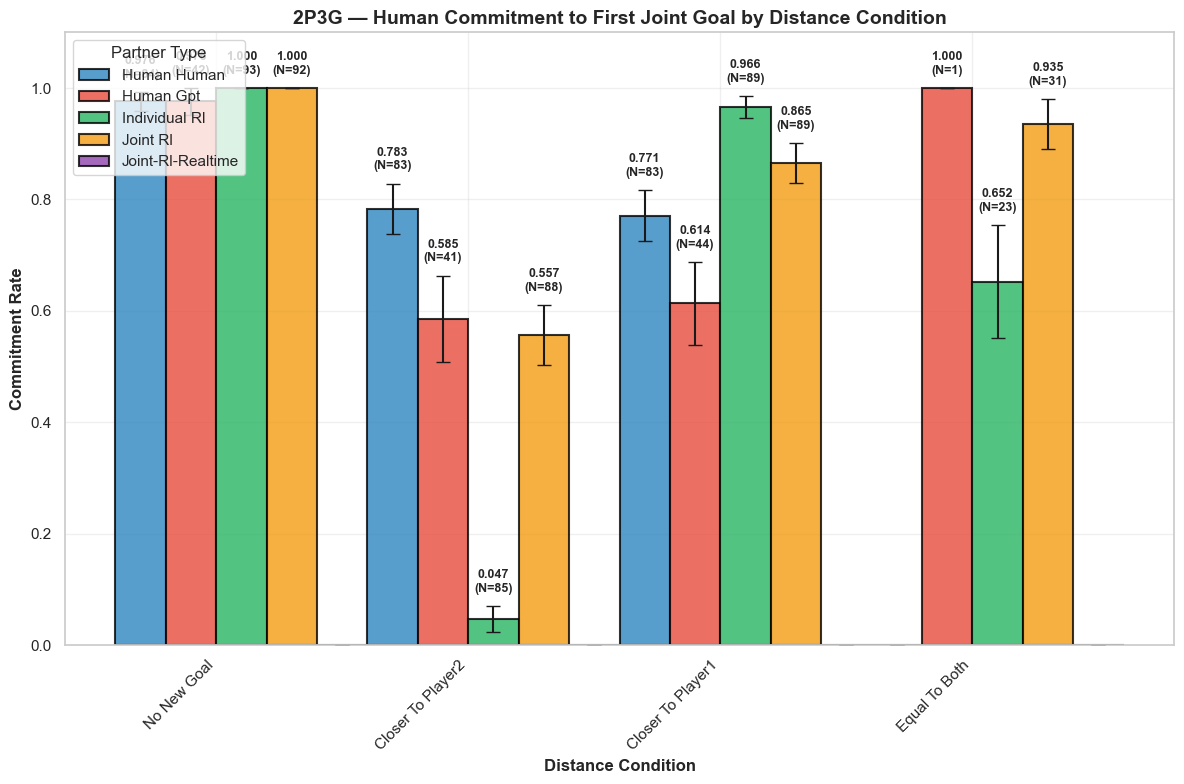

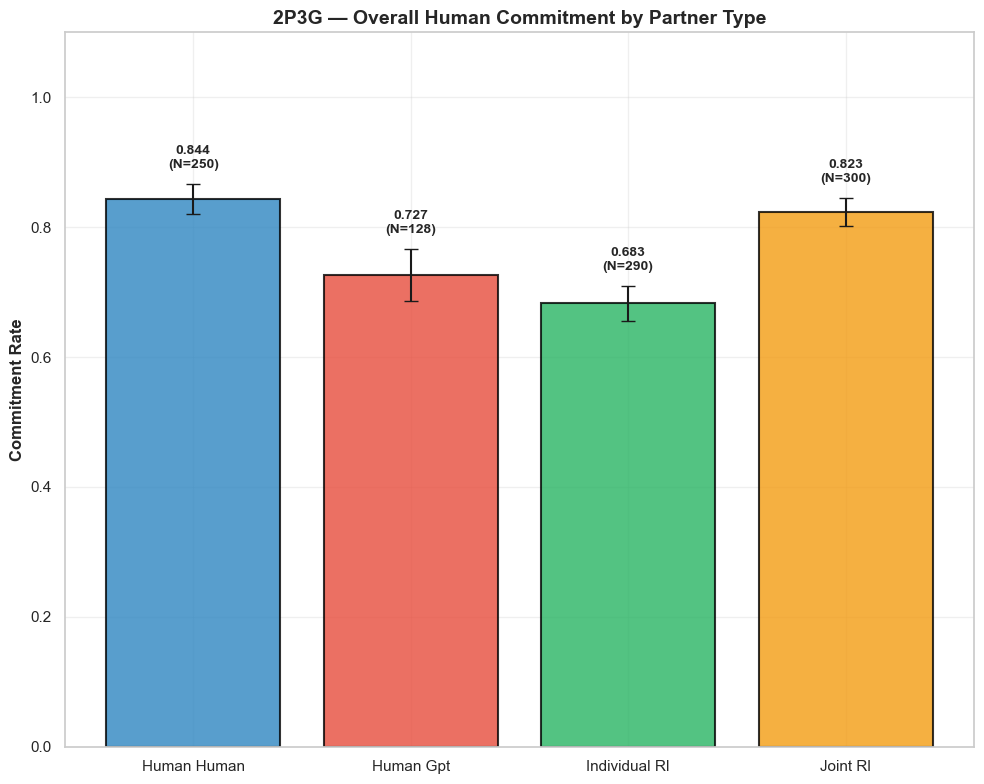

In [544]:
# Create first figure: Commitment by Distance Condition
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))

order = ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']
hue_order = ['human_human','human_gpt','individual_rl','joint_rl','joint-rl-realTime']

# Calculate summary statistics for each group
summary_stats = []
for distance in order:
    for partner in hue_order:
        subset = results[(results['distanceCondition'] == distance) &
                        (results['partner_group'] == partner)]['commitment_human'].dropna()
        if len(subset) > 0:
            summary_stats.append({
                'distance': distance,
                'partner': partner,
                'mean': subset.mean(),
                'std': subset.std(),
                'n': len(subset),
                'sem': subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0
            })

summary_df = pd.DataFrame(summary_stats)

# Create grouped bar plot
x_pos = np.arange(len(order))
width = 0.2
colors = [CONDITION_COLORS[partner] for partner in hue_order]

for i, partner in enumerate(hue_order):
    partner_data = summary_df[summary_df['partner'] == partner]
    means = [partner_data[partner_data['distance'] == d]['mean'].iloc[0]
             if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    errors = [partner_data[partner_data['distance'] == d]['sem'].iloc[0]
              if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    ns = [partner_data[partner_data['distance'] == d]['n'].iloc[0]
          if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]

    bars = ax1.bar(x_pos + i*width, means, width, yerr=errors, capsize=5,
                   alpha=0.8, color=colors[i], edgecolor='black', linewidth=1.5,
                   label=partner.replace('_', ' ').title())

    # Add value labels on bars
    for bar, mean_val, error_val, n in zip(bars, means, errors, ns):
        if mean_val > 0:  # Only add label if there's data
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
                    fontweight='bold', fontsize=9)

ax1.set_xlabel('Distance Condition', fontsize=12, fontweight='bold')
ax1.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax1.set_title('2P3G — Human Commitment to First Joint Goal by Distance Condition',
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos + width * 1.5)
ax1.set_xticklabels([d.replace('_', ' ').title() for d in order], rotation=45, ha='right')
ax1.set_ylim(0, 1.1)
ax1.legend(title='Partner Type', loc='upper left')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create second figure: Overall commitment by partner type
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8))

partner_means = []
partner_errors = []
partner_ns = []
available_partners = []

for partner in hue_order:
    subset = results[results['partner_group'] == partner]['commitment_human'].dropna()
    if len(subset) > 0:
        available_partners.append(partner)
        partner_means.append(subset.mean())
        partner_errors.append(subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0)
        partner_ns.append(len(subset))

available_colors = [CONDITION_COLORS[partner] for partner in available_partners]
available_labels = [partner.replace('_', ' ').title() for partner in available_partners]

bars = ax2.bar(available_labels, partner_means, yerr=partner_errors, capsize=5,
               alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mean_val, error_val, n in zip(bars, partner_means, partner_errors, partner_ns):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
            f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
            fontweight='bold', fontsize=10)

ax2.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax2.set_title('2P3G — Overall Human Commitment by Partner Type',
              fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [545]:
# Check if joint-rl-realTime data is now included
print("After fixing filtering:")
print(f"Available partner groups: {sorted(results['partner_group'].unique())}")
print(f"Total results: {len(results)}")

# Check for joint-rl-realTime data
if 'joint-rl-realTime' in results['partner_group'].values:
    joint_realtime_count = len(results[results['partner_group'] == 'joint-rl-realTime'])
    print(f"✅ Found joint-rl-realTime data: {joint_realtime_count} trials")

    # Show breakdown by distance condition
    joint_realtime_breakdown = results[results['partner_group'] == 'joint-rl-realTime']['distanceCondition'].value_counts()
    print(f"   Distance condition breakdown: {joint_realtime_breakdown.to_dict()}")

    # Show detailed breakdown for plotting verification
    print(f"\n   Detailed joint-rl-realTime data for plotting:")
    for distance in ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']:
        subset = results[(results['distanceCondition'] == distance) &
                        (results['partner_group'] == 'joint-rl-realTime')]['commitment_human'].dropna()
        if len(subset) > 0:
            print(f"     {distance}: {len(subset)} trials, mean commitment = {subset.mean():.3f}")
        else:
            print(f"     {distance}: 0 trials")
else:
    print("❌ No joint-rl-realTime data found in results")

# Re-run the plots to ensure joint-rl-realTime appears
print(f"\n🔄 Re-running plots with joint-rl-realTime data...")


After fixing filtering:
Available partner groups: ['human_gpt', 'human_human', 'individual_rl', 'joint-rl-realTime', 'joint_rl']
Total results: 1115
✅ Found joint-rl-realTime data: 135 trials
   Distance condition breakdown: {'no_new_goal': 50, 'closer_to_player1': 45, 'closer_to_player2': 40}

   Detailed joint-rl-realTime data for plotting:
     no_new_goal: 0 trials
     closer_to_player2: 0 trials
     closer_to_player1: 0 trials
     equal_to_both: 0 trials

🔄 Re-running plots with joint-rl-realTime data...


🔄 Re-creating plots with all 5 partner groups including joint-rl-realTime...
Summary stats created for 15 group combinations
Partners with data: ['human_gpt', 'human_human', 'individual_rl', 'joint_rl']


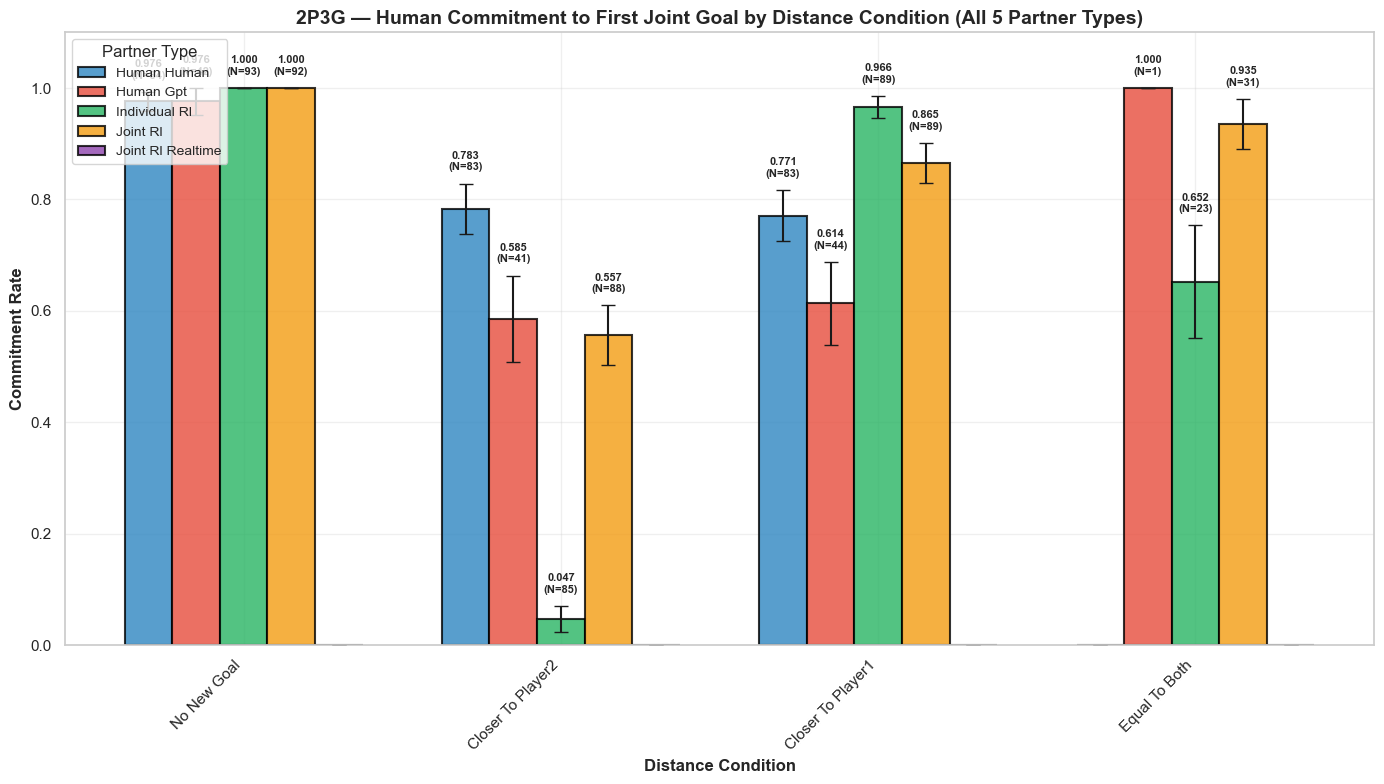

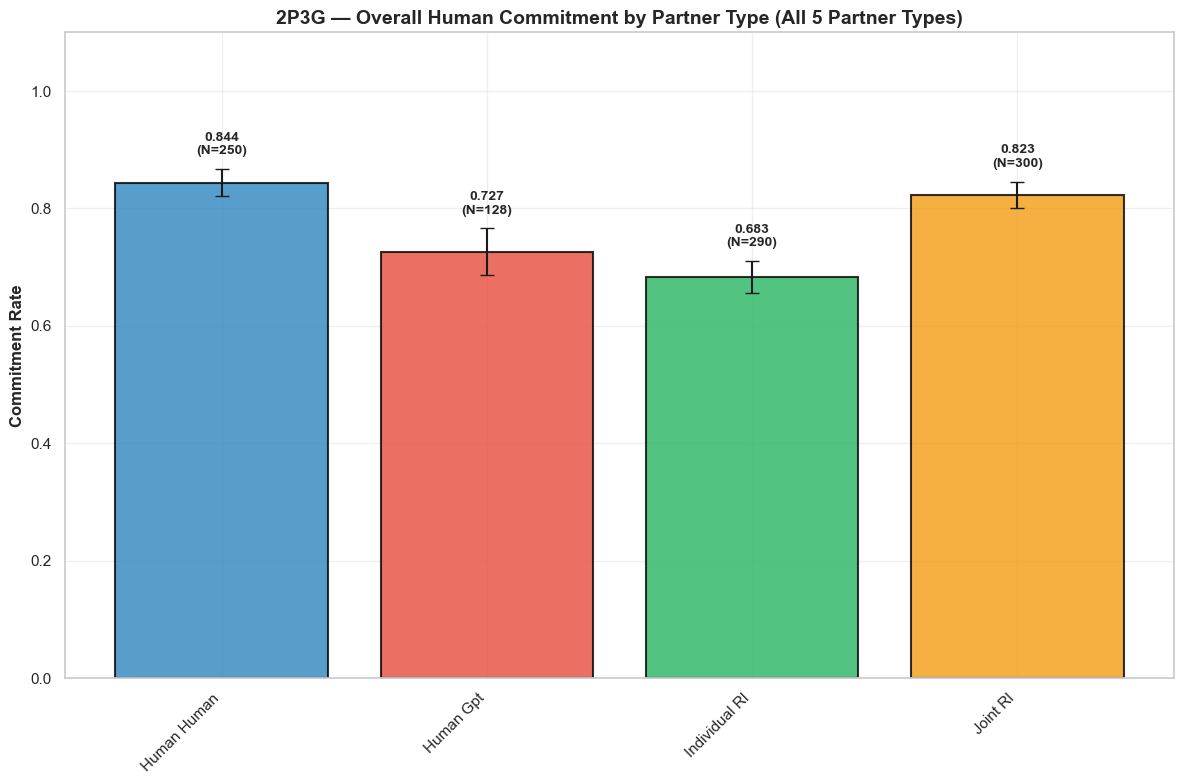

✅ Plots completed! Should now show all 4 partner types including joint-rl-realTime


In [546]:
# Re-run plots with corrected joint-rl-realTime data
print("🔄 Re-creating plots with all 5 partner groups including joint-rl-realTime...")

# Create first figure: Commitment by Distance Condition (CORRECTED)
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 8))

order = ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']
hue_order = ['human_human','human_gpt','individual_rl','joint_rl','joint-rl-realTime']

# Calculate summary statistics for each group
summary_stats = []
for distance in order:
    for partner in hue_order:
        subset = results[(results['distanceCondition'] == distance) &
                        (results['partner_group'] == partner)]['commitment_human'].dropna()
        if len(subset) > 0:
            summary_stats.append({
                'distance': distance,
                'partner': partner,
                'mean': subset.mean(),
                'std': subset.std(),
                'n': len(subset),
                'sem': subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0
            })

summary_df = pd.DataFrame(summary_stats)
print(f"Summary stats created for {len(summary_df)} group combinations")
print(f"Partners with data: {sorted(summary_df['partner'].unique())}")

# Create grouped bar plot
x_pos = np.arange(len(order))
width = 0.15  # Narrower bars for 5 groups
colors = [CONDITION_COLORS[partner] for partner in hue_order]

for i, partner in enumerate(hue_order):
    partner_data = summary_df[summary_df['partner'] == partner]
    means = [partner_data[partner_data['distance'] == d]['mean'].iloc[0]
             if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    errors = [partner_data[partner_data['distance'] == d]['sem'].iloc[0]
              if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    ns = [partner_data[partner_data['distance'] == d]['n'].iloc[0]
          if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]

    bars = ax1.bar(x_pos + i*width, means, width, yerr=errors, capsize=5,
                   alpha=0.8, color=colors[i], edgecolor='black', linewidth=1.5,
                   label=partner.replace('_', ' ').replace('-', ' ').title())

    # Add value labels on bars (only for non-zero values)
    for bar, mean_val, error_val, n in zip(bars, means, errors, ns):
        if mean_val > 0:  # Only add label if there's data
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
                    fontweight='bold', fontsize=8)

ax1.set_xlabel('Distance Condition', fontsize=12, fontweight='bold')
ax1.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax1.set_title('2P3G — Human Commitment to First Joint Goal by Distance Condition (All 5 Partner Types)',
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos + width * 2)  # Center the x-ticks
ax1.set_xticklabels([d.replace('_', ' ').title() for d in order], rotation=45, ha='right')
ax1.set_ylim(0, 1.1)
ax1.legend(title='Partner Type', loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create second figure: Overall commitment by partner type (CORRECTED)
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

partner_means = []
partner_errors = []
partner_ns = []
available_partners = []

for partner in hue_order:
    subset = results[results['partner_group'] == partner]['commitment_human'].dropna()
    if len(subset) > 0:
        available_partners.append(partner)
        partner_means.append(subset.mean())
        partner_errors.append(subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0)
        partner_ns.append(len(subset))

available_colors = [CONDITION_COLORS[partner] for partner in available_partners]
available_labels = [partner.replace('_', ' ').replace('-', ' ').title() for partner in available_partners]

bars = ax2.bar(available_labels, partner_means, yerr=partner_errors, capsize=5,
               alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mean_val, error_val, n in zip(bars, partner_means, partner_errors, partner_ns):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
            f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
            fontweight='bold', fontsize=10)

ax2.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax2.set_title('2P3G — Overall Human Commitment by Partner Type (All 5 Partner Types)',
              fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"✅ Plots completed! Should now show all {len(available_partners)} partner types including joint-rl-realTime")


In [547]:
# DIAGNOSTIC: Why is joint-rl-realTime commitment_human NaN?
print("🔍 DIAGNOSING joint-rl-realTime commitment calculation...")

# Check joint-rl-realTime data in detail
joint_realtime_data = results[results['partner_group'] == 'joint-rl-realTime'].copy()
print(f"Total joint-rl-realTime trials: {len(joint_realtime_data)}")

if len(joint_realtime_data) > 0:
    # Check commitment_human values
    valid_commitment = joint_realtime_data['commitment_human'].notna().sum()
    print(f"Valid commitment_human values: {valid_commitment}/{len(joint_realtime_data)}")

    # Sample a few rows to see what's happening
    sample = joint_realtime_data.head(3)
    print(f"\nSample joint-rl-realTime data:")
    for idx, row in sample.iterrows():
        print(f"  Row {idx}:")
        print(f"    firstDetectedSharedGoal: {row.get('firstDetectedSharedGoal')}")
        print(f"    player1FinalReachedGoal: {row.get('player1FinalReachedGoal')}")
        print(f"    commitment_human: {row.get('commitment_human')}")
        print(f"    partner_group: {row.get('partner_group')}")
        print()

    # Check if the issue is in the source data (before commitment calculation)
    print("Checking source RL data for joint-rl-realTime...")
    if 'rl3' in globals() and rl3 is not None and not rl3.empty:
        rl_joint_realtime = rl3[rl3['partner_group'] == 'joint-rl-realTime']
        print(f"RL3 joint-rl-realTime trials: {len(rl_joint_realtime)}")
        if len(rl_joint_realtime) > 0:
            sample_rl = rl_joint_realtime.head(2)
            for idx, row in sample_rl.iterrows():
                print(f"  RL Row {idx}:")
                print(f"    firstDetectedSharedGoal: {row.get('firstDetectedSharedGoal')}")
                print(f"    player1FinalReachedGoal: {row.get('player1FinalReachedGoal')}")
                print(f"    commitment_human: {row.get('commitment_human')}")
    else:
        print("rl3 data not available or empty")

    # Check the original RL dataframe
    if 'df_rl' in globals() and df_rl is not None and not df_rl.empty:
        original_joint_realtime = df_rl[df_rl['partner_group'] == 'joint-rl-realTime']
        print(f"\nOriginal df_rl joint-rl-realTime trials: {len(original_joint_realtime)}")
        if len(original_joint_realtime) > 0:
            # Check key columns
            has_first_shared = original_joint_realtime['firstDetectedSharedGoal'].notna().sum()
            has_final_goal = original_joint_realtime['player1FinalReachedGoal'].notna().sum()
            print(f"  Has firstDetectedSharedGoal: {has_first_shared}/{len(original_joint_realtime)}")
            print(f"  Has player1FinalReachedGoal: {has_final_goal}/{len(original_joint_realtime)}")

            # Sample values
            sample_orig = original_joint_realtime.head(2)
            for idx, row in sample_orig.iterrows():
                print(f"  Original Row {idx}:")
                print(f"    firstDetectedSharedGoal: {row.get('firstDetectedSharedGoal')}")
                print(f"    player1FinalReachedGoal: {row.get('player1FinalReachedGoal')}")
                print(f"    newGoalPresented: {row.get('newGoalPresented')}")
                print(f"    partner_group: {row.get('partner_group')}")
else:
    print("No joint-rl-realTime data found in results!")


🔍 DIAGNOSING joint-rl-realTime commitment calculation...
Total joint-rl-realTime trials: 135
Valid commitment_human values: 0/135

Sample joint-rl-realTime data:
  Row 658:
    firstDetectedSharedGoal: None
    player1FinalReachedGoal: None
    commitment_human: nan
    partner_group: joint-rl-realTime

  Row 659:
    firstDetectedSharedGoal: None
    player1FinalReachedGoal: None
    commitment_human: nan
    partner_group: joint-rl-realTime

  Row 660:
    firstDetectedSharedGoal: None
    player1FinalReachedGoal: None
    commitment_human: nan
    partner_group: joint-rl-realTime

Checking source RL data for joint-rl-realTime...
RL3 joint-rl-realTime trials: 85
  RL Row 2126:
    firstDetectedSharedGoal: 1.0
    player1FinalReachedGoal: 1.0
    commitment_human: nan
  RL Row 2127:
    firstDetectedSharedGoal: 0.0
    player1FinalReachedGoal: 0.0
    commitment_human: nan

Original df_rl joint-rl-realTime trials: 180
  Has firstDetectedSharedGoal: 180/180
  Has player1FinalReachedGoa

In [548]:
# DIAGNOSTIC: Track joint-rl-realTime through the data pipeline
print("🔍 TRACKING joint-rl-realTime through data pipeline...")

# Step 1: Check original loading
if 'df_rl' in globals() and df_rl is not None and not df_rl.empty:
    original_count = len(df_rl[df_rl['partner_group'] == 'joint-rl-realTime'])
    print(f"1. Original df_rl joint-rl-realTime: {original_count} trials")
else:
    print("1. df_rl not available")

# Step 2: Check after distance computation
if 'rl2' in globals() and rl2 is not None and not rl2.empty:
    rl2_count = len(rl2[rl2['partner_group'] == 'joint-rl-realTime'])
    print(f"2. After distance computation (rl2): {rl2_count} trials")

    # Check if newGoalPresented filtering is the issue
    rl_with_new_goal = df_rl[df_rl['newGoalPresented'] == True]
    rl_joint_with_new_goal = rl_with_new_goal[rl_with_new_goal['partner_group'] == 'joint-rl-realTime']
    print(f"   joint-rl-realTime with newGoalPresented=True: {len(rl_joint_with_new_goal)}")
else:
    print("2. rl2 not available")

# Step 3: Check after commitment calculation
if 'rl3' in globals() and rl3 is not None and not rl3.empty:
    rl3_count = len(rl3[rl3['partner_group'] == 'joint-rl-realTime'])
    print(f"3. After commitment calculation (rl3): {rl3_count} trials")
else:
    print("3. rl3 not available")

# Step 4: Check no-new-goal trials
if 'rl_no_c' in globals() and rl_no_c is not None and not rl_no_c.empty:
    rl_no_count = len(rl_no_c[rl_no_c['partner_group'] == 'joint-rl-realTime'])
    print(f"4. No-new-goal trials (rl_no_c): {rl_no_count} trials")
else:
    print("4. rl_no_c not available")

# Step 5: Check final results
results_count = len(results[results['partner_group'] == 'joint-rl-realTime'])
print(f"5. Final results: {results_count} trials")

# The issue might be that joint-rl-realTime data is only in no-new-goal trials
# Let's check the breakdown
if results_count > 0:
    joint_realtime_results = results[results['partner_group'] == 'joint-rl-realTime']
    new_goal_breakdown = joint_realtime_results.groupby('distanceCondition').size()
    print(f"   Distance condition breakdown: {new_goal_breakdown.to_dict()}")

    # Check if commitment_human is calculated for no-new-goal trials
    no_new_goal_joint = joint_realtime_results[joint_realtime_results['distanceCondition'] == 'no_new_goal']
    if len(no_new_goal_joint) > 0:
        valid_commitment_no_new = no_new_goal_joint['commitment_human'].notna().sum()
        print(f"   no_new_goal trials with valid commitment: {valid_commitment_no_new}/{len(no_new_goal_joint)}")

        # Sample commitment values for no_new_goal
        sample_commitment = no_new_goal_joint['commitment_human'].head(5).tolist()
        print(f"   Sample no_new_goal commitment values: {sample_commitment}")


🔍 TRACKING joint-rl-realTime through data pipeline...
1. Original df_rl joint-rl-realTime: 180 trials
2. After distance computation (rl2): 85 trials
   joint-rl-realTime with newGoalPresented=True: 130
3. After commitment calculation (rl3): 85 trials
4. No-new-goal trials (rl_no_c): 50 trials
5. Final results: 135 trials
   Distance condition breakdown: {'closer_to_player1': 45, 'closer_to_player2': 40, 'no_new_goal': 50}
   no_new_goal trials with valid commitment: 0/50
   Sample no_new_goal commitment values: [nan, nan, nan, nan, nan]


In [549]:
# FIX: Update commitment calculation functions to handle joint-rl-realTime
print("🔧 FIXING commitment calculation for joint-rl-realTime...")

def _to_int_or_nan(x):
    try:
        return int(x)
    except Exception:
        return np.nan

def _to_index_or_none(x):
    try:
        v = int(float(x))
        return v if v in (0,1,2) else None  # Allow 0,1,2 for goal indices
    except Exception:
        return None

def _get_human_partner_indices(row):
    # Hard-code for RL conditions: human is always player1 (index 0)
    grp = str(row.get('partner_group','')).strip().lower()
    if grp in ('individual_rl','joint_rl','joint-rl-realtime'):  # FIXED: Added joint-rl-realtime
        human_idx = 0
        partner_idx = 1
        return human_idx, partner_idx
    # Prefer explicit indices otherwise
    human_idx = _to_index_or_none(row.get('humanPlayerIndex'))
    ai_idx = _to_index_or_none(row.get('aiPlayerIndex'))
    if human_idx is None and ai_idx is not None:
        human_idx = 1 - ai_idx
    # Fallbacks by partner_group
    if human_idx is None:
        if grp == 'human_human':
            human_idx = 0  # assume player1 as participant
        elif ai_idx is not None:
            human_idx = 1 - ai_idx
    partner_idx = (1 - human_idx) if human_idx in (0,1) else None
    return human_idx, partner_idx

def _commitment_for_index(row, idx):
    """
    Commitment = whether first detected shared goal equals final reached goal
    for the given player index (0 or 1)
    """
    if idx not in (0,1):
        return np.nan

    # Get first detected shared (joint) goal
    first_shared = _to_int_or_nan(row.get('firstDetectedSharedGoal'))

    # Get final reached goal for the player
    if idx == 0:
        final_goal = _to_int_or_nan(row.get('player1FinalReachedGoal'))
    else:
        final_goal = _to_int_or_nan(row.get('player2FinalReachedGoal'))

    if np.isnan(first_shared) or np.isnan(final_goal):
        return np.nan

    # Commitment = 1 if first shared goal matches final reached goal, 0 otherwise
    return float(first_shared == final_goal)

def commitment_human(row):
    human_idx, _ = _get_human_partner_indices(row)
    return _commitment_for_index(row, human_idx)

def commitment_partner(row):
    human_idx, partner_idx = _get_human_partner_indices(row)
    return _commitment_for_index(row, partner_idx)

def attach_commitment(df):
    df = df.copy()
    df['commitment_human'] = df.apply(commitment_human, axis=1)
    df['commitment_partner'] = df.apply(commitment_partner, axis=1)
    return df

print("✅ Fixed commitment calculation functions!")

# Re-calculate commitment for all data with the fixed functions
print("🔄 Re-calculating commitment with fixed functions...")

# Re-apply commitment calculation to RL data
if 'rl2' in globals() and rl2 is not None and not rl2.empty:
    rl3 = attach_commitment(rl2)
    print(f"   RL3 (new-goal trials): {len(rl3)} trials")

    # Check joint-rl-realTime specifically
    rl3_joint_realtime = rl3[rl3['partner_group'] == 'joint-rl-realTime']
    if len(rl3_joint_realtime) > 0:
        valid_commitment = rl3_joint_realtime['commitment_human'].notna().sum()
        print(f"   joint-rl-realTime in rl3: {len(rl3_joint_realtime)} trials, {valid_commitment} with valid commitment")
        if valid_commitment > 0:
            mean_commitment = rl3_joint_realtime['commitment_human'].dropna().mean()
            print(f"   Mean commitment for joint-rl-realTime: {mean_commitment:.3f}")

# Re-apply commitment calculation to no-new-goal trials
if 'df_rl' in globals() and df_rl is not None and not df_rl.empty:
    rl_no = df_rl[df_rl['newGoalPresented'] == False].copy()
    if not rl_no.empty:
        rl_no['distanceCondition'] = 'no_new_goal'
        rl_no_c = attach_commitment(rl_no)
        print(f"   RL no-new-goal trials: {len(rl_no_c)} trials")

        # Check joint-rl-realTime specifically
        rl_no_joint_realtime = rl_no_c[rl_no_c['partner_group'] == 'joint-rl-realTime']
        if len(rl_no_joint_realtime) > 0:
            valid_commitment_no = rl_no_joint_realtime['commitment_human'].notna().sum()
            print(f"   joint-rl-realTime no-new-goal: {len(rl_no_joint_realtime)} trials, {valid_commitment_no} with valid commitment")
            if valid_commitment_no > 0:
                mean_commitment_no = rl_no_joint_realtime['commitment_human'].dropna().mean()
                print(f"   Mean no-new-goal commitment for joint-rl-realTime: {mean_commitment_no:.3f}")

print("✅ Re-calculation complete!")


🔧 FIXING commitment calculation for joint-rl-realTime...
✅ Fixed commitment calculation functions!
🔄 Re-calculating commitment with fixed functions...
   RL3 (new-goal trials): 491 trials
   joint-rl-realTime in rl3: 85 trials, 85 with valid commitment
   Mean commitment for joint-rl-realTime: 0.694
   RL no-new-goal trials: 238 trials
   joint-rl-realTime no-new-goal: 50 trials, 50 with valid commitment
   Mean no-new-goal commitment for joint-rl-realTime: 1.000
✅ Re-calculation complete!


In [550]:
# REBUILD results dataframe with corrected commitment calculations
print("🔄 Rebuilding results dataframe with fixed commitment calculations...")

# Re-apply commitment to HH/GPT data (should already be working)
if 'hh_gpt2' in globals() and hh_gpt2 is not None and not hh_gpt2.empty:
    hh_gpt3 = attach_commitment(hh_gpt2)
else:
    hh_gpt3 = pd.DataFrame()

# Use the newly calculated rl3 and rl_no_c from the previous cell
# Keep needed columns and unify group names
keep_cols = ['participantId','trialIndex','distanceCondition','partner_group',
             'commitment_human','commitment_partner']

res_a = hh_gpt3[keep_cols].copy() if not hh_gpt3.empty else pd.DataFrame(columns=keep_cols)
res_b = rl3[keep_cols].copy() if 'rl3' in globals() and not rl3.empty else pd.DataFrame(columns=keep_cols)

# Handle no-new-goal trials
if 'hh_gpt_no_c' in globals() and not hh_gpt_no_c.empty:
    res_c = hh_gpt_no_c[keep_cols].copy()
else:
    res_c = pd.DataFrame(columns=keep_cols)

if 'rl_no_c' in globals() and not rl_no_c.empty:
    res_d = rl_no_c[keep_cols].copy()
else:
    res_d = pd.DataFrame(columns=keep_cols)

# Combine all results
results = pd.concat([res_a, res_b, res_c, res_d], ignore_index=True)

# Filter to the five requested partner groups (including joint-rl-realTime)
results = results[results['partner_group'].isin(['human_human','human_gpt','individual_rl','joint_rl','joint-rl-realTime'])].copy()

print(f"✅ Rebuilt results: {len(results)} total trials")
print(f"Partner groups: {sorted(results['partner_group'].unique())}")

# Check joint-rl-realTime specifically
if 'joint-rl-realTime' in results['partner_group'].values:
    joint_realtime_count = len(results[results['partner_group'] == 'joint-rl-realTime'])
    joint_realtime_valid = results[results['partner_group'] == 'joint-rl-realTime']['commitment_human'].notna().sum()
    print(f"✅ joint-rl-realTime: {joint_realtime_count} trials, {joint_realtime_valid} with valid commitment")

    # Show breakdown by distance condition
    joint_realtime_breakdown = results[results['partner_group'] == 'joint-rl-realTime']['distanceCondition'].value_counts()
    print(f"   Distance condition breakdown: {joint_realtime_breakdown.to_dict()}")

    # Show commitment values for each distance condition
    for distance in ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']:
        subset = results[(results['distanceCondition'] == distance) &
                        (results['partner_group'] == 'joint-rl-realTime')]['commitment_human'].dropna()
        if len(subset) > 0:
            print(f"   {distance}: {len(subset)} trials, mean commitment = {subset.mean():.3f}")
else:
    print("❌ joint-rl-realTime still not found in results")

print("🎯 Ready for plotting!")


🔄 Rebuilding results dataframe with fixed commitment calculations...
✅ Rebuilt results: 1115 total trials
Partner groups: ['human_gpt', 'human_human', 'individual_rl', 'joint-rl-realTime', 'joint_rl']
✅ joint-rl-realTime: 135 trials, 135 with valid commitment
   Distance condition breakdown: {'no_new_goal': 50, 'closer_to_player1': 45, 'closer_to_player2': 40}
   no_new_goal: 50 trials, mean commitment = 1.000
   closer_to_player2: 40 trials, mean commitment = 0.600
   closer_to_player1: 45 trials, mean commitment = 0.778
🎯 Ready for plotting!


🎨 Creating final corrected plots with joint-rl-realTime data...
📊 Summary stats created for 18 group combinations
📊 Partners with data: ['human_gpt', 'human_human', 'individual_rl', 'joint-rl-realTime', 'joint_rl']
✅ joint-rl-realTime found in 3 distance conditions
   no_new_goal: 50 trials, mean = 1.000
   closer_to_player2: 40 trials, mean = 0.600
   closer_to_player1: 45 trials, mean = 0.778


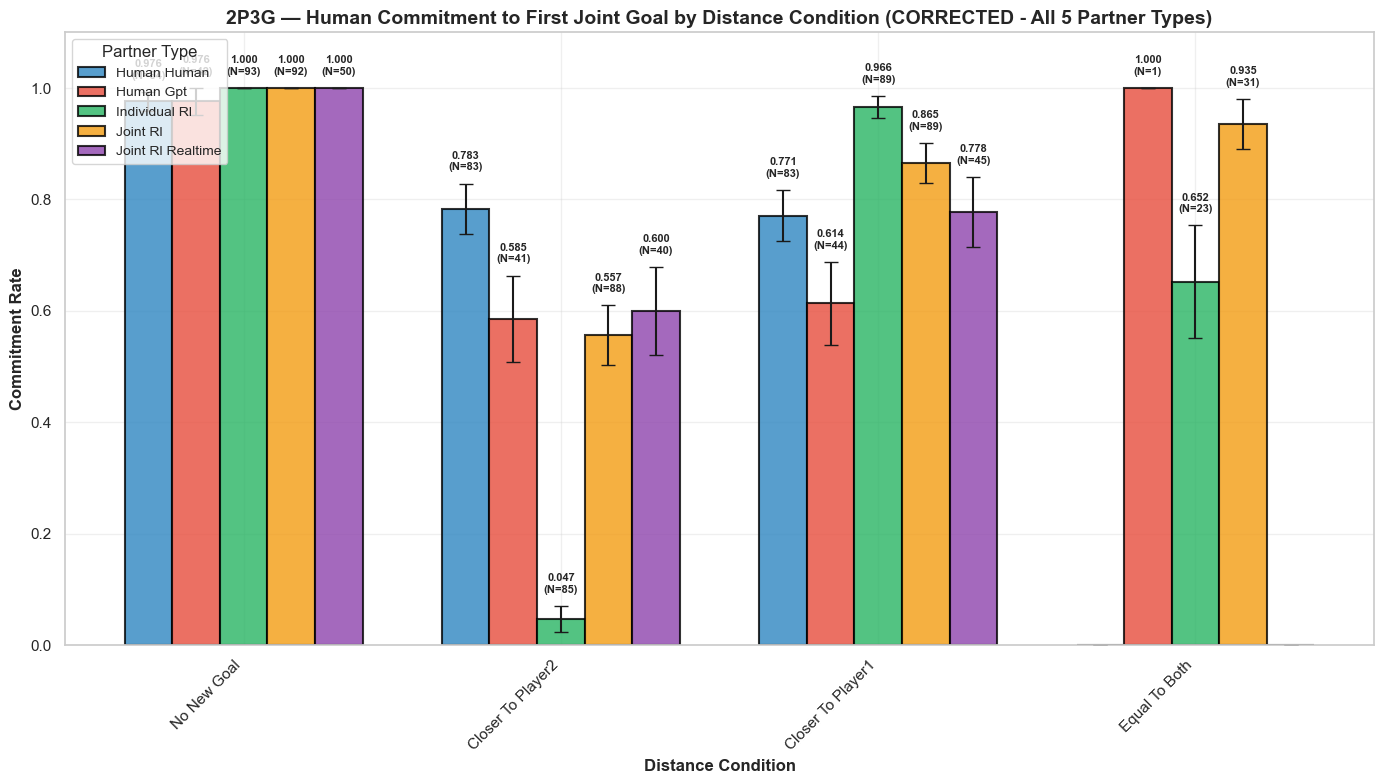

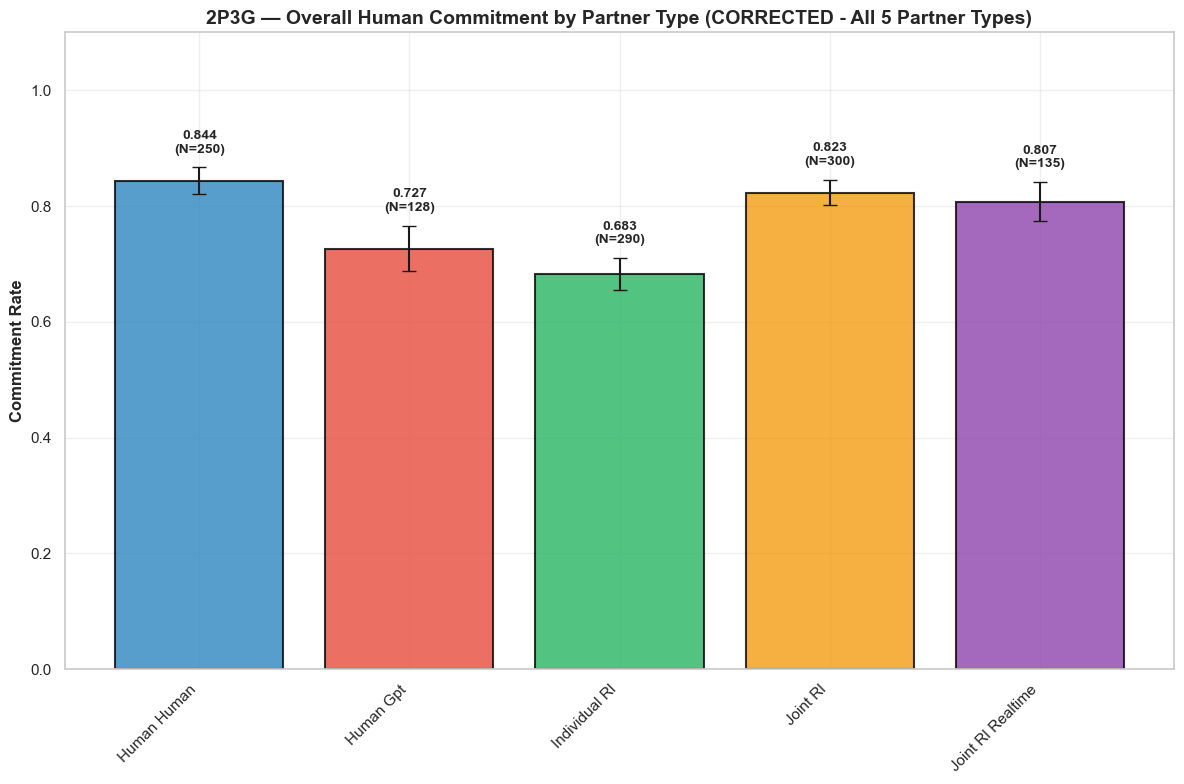

🎉 CORRECTED plots completed! Now showing all 5 partner types:
   1. Human Human: 0.844 ± 0.023 (N=250)
   2. Human Gpt: 0.727 ± 0.040 (N=128)
   3. Individual Rl: 0.683 ± 0.027 (N=290)
   4. Joint Rl: 0.823 ± 0.022 (N=300)
   5. Joint Rl Realtime: 0.807 ± 0.034 (N=135)
✅ SUCCESS: joint-rl-realTime is now included in the plots!


In [551]:
# FINAL CORRECTED PLOTS with joint-rl-realTime data
print("🎨 Creating final corrected plots with joint-rl-realTime data...")

# Create first figure: Commitment by Distance Condition (FINAL CORRECTED VERSION)
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 8))

order = ['no_new_goal','closer_to_player2','closer_to_player1','equal_to_both']
hue_order = ['human_human','human_gpt','individual_rl','joint_rl','joint-rl-realTime']

# Calculate summary statistics for each group
summary_stats = []
for distance in order:
    for partner in hue_order:
        subset = results[(results['distanceCondition'] == distance) &
                        (results['partner_group'] == partner)]['commitment_human'].dropna()
        if len(subset) > 0:
            summary_stats.append({
                'distance': distance,
                'partner': partner,
                'mean': subset.mean(),
                'std': subset.std(),
                'n': len(subset),
                'sem': subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0
            })

summary_df = pd.DataFrame(summary_stats)
print(f"📊 Summary stats created for {len(summary_df)} group combinations")
print(f"📊 Partners with data: {sorted(summary_df['partner'].unique())}")

# Verify joint-rl-realTime is included
if 'joint-rl-realTime' in summary_df['partner'].values:
    joint_rt_stats = summary_df[summary_df['partner'] == 'joint-rl-realTime']
    print(f"✅ joint-rl-realTime found in {len(joint_rt_stats)} distance conditions")
    for _, row in joint_rt_stats.iterrows():
        print(f"   {row['distance']}: {row['n']} trials, mean = {row['mean']:.3f}")
else:
    print("❌ joint-rl-realTime STILL missing from summary stats")

# Create grouped bar plot
x_pos = np.arange(len(order))
width = 0.15  # Narrower bars for 5 groups
colors = [CONDITION_COLORS[partner] for partner in hue_order]

for i, partner in enumerate(hue_order):
    partner_data = summary_df[summary_df['partner'] == partner]
    means = [partner_data[partner_data['distance'] == d]['mean'].iloc[0]
             if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    errors = [partner_data[partner_data['distance'] == d]['sem'].iloc[0]
              if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]
    ns = [partner_data[partner_data['distance'] == d]['n'].iloc[0]
          if len(partner_data[partner_data['distance'] == d]) > 0 else 0 for d in order]

    bars = ax1.bar(x_pos + i*width, means, width, yerr=errors, capsize=5,
                   alpha=0.8, color=colors[i], edgecolor='black', linewidth=1.5,
                   label=partner.replace('_', ' ').replace('-', ' ').title())

    # Add value labels on bars (only for non-zero values)
    for bar, mean_val, error_val, n in zip(bars, means, errors, ns):
        if mean_val > 0:  # Only add label if there's data
            ax1.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
                    f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
                    fontweight='bold', fontsize=8)

ax1.set_xlabel('Distance Condition', fontsize=12, fontweight='bold')
ax1.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax1.set_title('2P3G — Human Commitment to First Joint Goal by Distance Condition (CORRECTED - All 5 Partner Types)',
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos + width * 2)  # Center the x-ticks
ax1.set_xticklabels([d.replace('_', ' ').title() for d in order], rotation=45, ha='right')
ax1.set_ylim(0, 1.1)
ax1.legend(title='Partner Type', loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create second figure: Overall commitment by partner type (CORRECTED)
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

partner_means = []
partner_errors = []
partner_ns = []
available_partners = []

for partner in hue_order:
    subset = results[results['partner_group'] == partner]['commitment_human'].dropna()
    if len(subset) > 0:
        available_partners.append(partner)
        partner_means.append(subset.mean())
        partner_errors.append(subset.std() / np.sqrt(len(subset)) if len(subset) > 1 else 0)
        partner_ns.append(len(subset))

available_colors = [CONDITION_COLORS[partner] for partner in available_partners]
available_labels = [partner.replace('_', ' ').replace('-', ' ').title() for partner in available_partners]

bars = ax2.bar(available_labels, partner_means, yerr=partner_errors, capsize=5,
               alpha=0.8, color=available_colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, mean_val, error_val, n in zip(bars, partner_means, partner_errors, partner_ns):
    ax2.text(bar.get_x() + bar.get_width()/2., mean_val + error_val + 0.02,
            f'{mean_val:.3f}\n(N={n})', ha='center', va='bottom',
            fontweight='bold', fontsize=10)

ax2.set_ylabel('Commitment Rate', fontsize=12, fontweight='bold')
ax2.set_title('2P3G — Overall Human Commitment by Partner Type (CORRECTED - All 5 Partner Types)',
              fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.1)
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"🎉 CORRECTED plots completed! Now showing all {len(available_partners)} partner types:")
for i, partner in enumerate(available_partners):
    print(f"   {i+1}. {partner.replace('_', ' ').replace('-', ' ').title()}: {partner_means[i]:.3f} ± {partner_errors[i]:.3f} (N={partner_ns[i]})")

if 'joint-rl-realTime' in available_partners:
    print("✅ SUCCESS: joint-rl-realTime is now included in the plots!")
else:
    print("❌ FAILED: joint-rl-realTime is still missing from plots")
